# Clasificación de Histopatología de Cáncer de Pulmón
Para esto se usará el siguiente Pipeline:
1. **Organización de datos**
   - Confirmamos la estructura de los folds (`fold1` y `fold2`), cada uno con imágenes en carpetas por clase.  
   - Verificamos el número de imágenes por clase y fold, y calculamos pesos para tratar el desbalance.  

2. **Definición del pipeline**
   - Separamos parámetros del entorno (como rutas y clases) de los hiperparámetros del modelo (como tamaño de imagen, batch size o número de épocas).  
   - Implementamos funciones auxiliares para reproducibilidad, transformaciones de datos, balanceo de clases y métricas.  

3. **Modelo base**
   - Usamos ResNet18 preentrenada en ImageNet.  
   - Entrenamos en dos fases:  
     - Head training: solo la última capa.  
     - Fine-tuning: toda la red con learning rate menor.  

4. **Validación cruzada (2-fold CV)**
   - Entrenamos dos modelos:  
     - Fold A: train en `fold1`, test en `fold2`.  
     - Fold B: train en `fold2`, test en `fold1`.  
   - Reportamos accuracy, F1-macro y matrices de confusión.  
   - Calculamos métricas promedio como estimación final del desempeño.  

5. **Resultados y análisis**
   - Guardamos artefactos (pesos entrenados, métricas en JSON, matrices de confusión).  
   - Interpretamos el rendimiento del modelo y sus errores más comunes.

In [29]:
# Imports
import os
from pathlib import Path
from typing import List, Tuple, Dict
from collections import Counter
import json
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import Image as IPyImage, display

In [26]:
# Parámetros, hiperparámetros y extracción de imagenes
DATA_ROOT = Path("data") # Tiene fold1 y fold2
OUT_DIR = Path("outputs") # Guardar métricas, figuras,...
OUT_DIR.mkdir(exist_ok=True)
CLASSES = ["nor","aca_bd","aca_md","aca_pd","scc_bd","scc_md","scc_pd"]
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS_HEAD = 4 # Épocas entrenando solo la cabeza
EPOCHS_FT = 8 # Épocas de fine-tuning
LR_HEAD = 1e-3 # LR fase 1
LR_FT = 1e-4 # LR fase 2
USE_SAMPLER = True # Sampler ponderado por clase en el train

In [27]:
# Construcción del modelo

# Para reproducibilidad, fijaré una semilla aleatoria del módulo random de Python, de Numpy, del generador de Pytorch y de las GPUs
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # Hace que las operaciones de cudnn sean deterministas
    torch.backends.cudnn.benchmark = False # Desactiva auto-tuning de cudnn

# Transforms para aumentos en train con resize+center crop en test
def build_transforms(split: str):
    if split == "train":
        aug = [
            transforms.Resize(256),
            transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),]  # varía brillo/contraste/saturación/tono levemente
    else: # No haré aumentos fuertes
        aug = [transforms.Resize(256), transforms.CenterCrop(IMG_SIZE)] # recorte centrado a IMG_SIZExIMG_SIZE
    
    # Para transformaciones comunes en ambos splits, como pasar PIL → tensor (C,H,W) en [0,1] y normalizar media RGB y desviación estándar
    aug += [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]
    return transforms.Compose(aug)

# Para devolver la lista tipo (ruta, etiqueta)
def scan_images_fold(fold_dir: Path) -> List[Tuple[str, int]]:
    items: List[Tuple[str, int]] = []
    for cls in CLASSES:
        cls_dir = fold_dir / cls
        if cls_dir.exists():
            y = CLASS_TO_IDX[cls]
            for dirpath, _, filenames in os.walk(cls_dir):
                for fn in filenames:
                    if fn.lower().endswith(".jpg"):
                        items.append((os.path.join(dirpath, fn), y))
    return items

# Dataset PyTorch personalizado
# Funciona de forma que recibe un directorio de fold (p.ej. data/fold1) y aplica transforms.
class HistologyDataset(Dataset):
    def __init__(self, root_dir: Path, split: str):
        self.items = scan_images_fold(root_dir) # escanea el fold y guarda lista de (ruta, y)
        self.t = build_transforms(split) # construye las transformaciones según el split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, i: int): # devuelve (tensor_imagen, etiqueta)
        path, y = self.items[i]
        img = Image.open(path).convert("RGB")
        return self.t(img), y # aplica transforms → tensor y devuelve junto con la etiqueta

# Sacar pesos por clase para balancear pérdida y sampler
def compute_class_weights(fold_dir: Path) -> torch.Tensor:
    items = scan_images_fold(fold_dir)
    counts = Counter([y for _, y in items])
    total = sum(counts.values()) if counts else 1
    weights = [total / counts.get(i, 1)
        for i in range(len(CLASSES))]
    return torch.tensor(weights, dtype=torch.float)   # devuelve tensor de pesos con tamaño = n_clases

# Para las métricas y matriz de confusión
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    return {"accuracy": float(accuracy_score(y_true, y_pred)), "macro_f1": float(f1_score(y_true, y_pred, average="macro"))}

def plot_confmat(y_true, y_pred, out_path: Path):
    cm = confusion_matrix( y_true, y_pred, labels=list(range(len(CLASSES))))
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
        xticklabels=CLASSES, yticklabels=CLASSES, ylabel="True label", 
        xlabel="Predicted label", title="Confusion Matrix",)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0 if cm.size else 0.5 # umbral para elegir color del texto encima de cada celda
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)

# Dataloaders
def make_loaders(train_dir: Path, test_dir: Path, bs: int = BATCH_SIZE, use_sampler: bool = True):
    train_ds = HistologyDataset(train_dir, "train") # dataset de entrenamiento (con aumentos)
    test_ds = HistologyDataset(test_dir, "test") # dataset de test/validación (sin aumentos fuertes)

    if use_sampler: # Si queremos muestrear por pesos de clase…
        labels = [y for _, y in scan_images_fold(train_dir)] # Lista de etiquetas del train (para construir pesos)
        cw = compute_class_weights(train_dir) # Pesos por clase (tensor con tamaño n_clases)
        sample_w = torch.tensor( # Convierte pesos por etiqueta en pesos por muestra
            [cw[y].item() for y in labels], dtype=torch.float)
        sampler = WeightedRandomSampler( sample_w, num_samples=len(sample_w), replacement=True)
        train_ld = DataLoader( # DataLoader del train usando el sampler
            train_ds, batch_size=bs, sampler=sampler,
            num_workers=0, pin_memory=False, persistent_workers=False)
    else: # Barajar sin sampler
        cw = compute_class_weights(train_dir)
        train_ld = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)

    test_ld = DataLoader( # DataLoader del test (orden fijo, sin shuffle)
        test_ds, batch_size=bs, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False)
    return train_ld, test_ld, cw # los dos loaders y los pesos por clase

# Modelo (ResNet18) y fases de entrenamiento
def build_model(nc: int = 7, freeze_backbone: bool = True) -> nn.Module:
    m = resnet18(weights=ResNet18_Weights.DEFAULT) # carga ResNet18 con pesos pre-entrenados en ImageNet
    in_f = m.fc.in_features
    m.fc = nn.Linear(in_f, nc)
    if freeze_backbone: # congelar el backbone
        for p in m.parameters(): p.requires_grad = False  # congela todos los parámetros
        for p in m.fc.parameters(): p.requires_grad = True # excepto la capa final que acabamos de crear
    return m

def train_epoch(model, loader, crit, opt, device):
    model.train() # El modelo se pone en modo entrenamiento para que haya dropout
    loss_sum = 0; n = 0; correct = 0  # acumulan pérdida y aciertos para promediar
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = crit(logits, y) # calcula la pérdida (CrossEntropy con pesos)
        loss.backward()  # backprop
        opt.step()
        loss_sum += loss.item() * y.size(0) 
        correct  += (logits.argmax(1) == y).sum().item()
        n += y.size(0)
    return loss_sum / n, correct / n

@torch.no_grad()
def eval_epoch(model, loader, crit, device):
    model.eval() # modo evaluación con dropout
    loss_sum = 0; n = 0; correct = 0
    y_true, y_pred = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit(logits, y)
        loss_sum += loss.item() * y.size(0)
        n += y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        y_true.extend(y.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    metrics = compute_metrics(y_true, y_pred)
    metrics.update({"loss": loss_sum / n, "acc": correct / n})
    return metrics, y_true, y_pred

# Entrena 2 fases (cabeza + fine-tuning), guarda best.pt y evalúa en test.
def run_fold(train_dir: Path, test_dir: Path, out_name: str, bs=BATCH_SIZE, epochs_head=EPOCHS_HEAD, epochs_ft=EPOCHS_FT,
             lr_head=LR_HEAD, lr_ft=LR_FT, use_sampler: bool = True):
    set_seed(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    out_dir = OUT_DIR / out_name # carpeta donde guardaremos artefactos de este fold
    out_dir.mkdir(parents=True, exist_ok=True)
    train_ld, test_ld, class_w = make_loaders( # construye DataLoaders y pesos de clase desde el train
        train_dir, test_dir, bs, use_sampler=use_sampler)
    model = build_model(freeze_backbone=True).to(device)
    crit = nn.CrossEntropyLoss(weight=class_w.to(device)) # define la pérdida ponderada por clase

    # Fase 1: entrenar solo la cabeza
    opt = torch.optim.Adam(model.fc.parameters(), lr=lr_head) # optimizador para la última capa (cabeza)
    best_acc, best_path = 0.0, out_dir / "best.pt" # seguimiento del mejor accuracy y path a .pt

    for ep in range(epochs_head):
        tr_loss, tr_acc = train_epoch(model, train_ld, crit, opt, device) # entrena una época
        te_metrics, _, _ = eval_epoch(model, test_ld, crit, device) # evalúa en test
        print(f"[Head {ep+1}/{epochs_head}] train_acc={tr_acc:.3f}  test_acc={te_metrics['accuracy']:.3f}")
        if te_metrics["accuracy"] > best_acc:
            best_acc = te_metrics["accuracy"]
            torch.save(model.state_dict(), best_path)

    # Fase 2: fine-tuning de TODA la red
    for p in model.parameters(): p.requires_grad = True # descongela todos los parámetros
    opt = torch.optim.Adam(model.parameters(), lr=lr_ft) # nuevo optimizador sobre toda la red

    for ep in range(epochs_ft):
        tr_loss, tr_acc = train_epoch(model, train_ld, crit, opt, device)
        te_metrics, _, _ = eval_epoch(model, test_ld, crit, device)
        print(f"[FT   {ep+1}/{epochs_ft}] train_acc={tr_acc:.3f}  test_acc={te_metrics['accuracy']:.3f}")
        if te_metrics["accuracy"] > best_acc:
            best_acc = te_metrics["accuracy"]
            torch.save(model.state_dict(), best_path)

    # Evaluación final con el mejor checkpoint
    state = torch.load(best_path, map_location=device)
    model.load_state_dict(state)
    test_metrics, y_true, y_pred = eval_epoch(model, test_ld, crit, device) # evalúa definitivamente con los mejores pesos

    # Guardado de artefactos
    with open(out_dir / "metrics.json", "w", encoding="utf-8") as f:
        json.dump(test_metrics, f, ensure_ascii=False, indent=2)
    plot_confmat(y_true, y_pred, out_dir / "confusion_matrix.png")

    print(f"✅ Fold listo: {out_name} | test_acc={test_metrics['accuracy']:.4f}  macroF1={test_metrics['macro_f1']:.4f}")
    return test_metrics, out_dir

In [28]:
# ENTRENAMIENTO

# Fold A: train = fold1, test = fold2
metrics_A, dir_A = run_fold(DATA_ROOT/"fold1", DATA_ROOT/"fold2", out_name="foldA_resnet18")

# Fold B: train = fold2, test = fold1
metrics_B, dir_B = run_fold(DATA_ROOT/"fold2", DATA_ROOT/"fold1", out_name="foldB_resnet18")

# Promedios
avg_acc = (metrics_A["accuracy"] + metrics_B["accuracy"]) / 2.0
avg_f1 = (metrics_A["macro_f1"] + metrics_B["macro_f1"]) / 2.0

summary = {"foldA": metrics_A, "foldB": metrics_B, "avg": {"accuracy": float(avg_acc), "macro_f1": float(avg_f1)}}
with open(OUT_DIR/"cv_summary.json","w",encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\n Resumen CV 2-fold")
print(f"Accuracy promedio: {avg_acc:.4f}")
print(f"Macro-F1 promedio: {avg_f1:.4f}")
print(f"Artefactos guardados en: {OUT_DIR.resolve()}")

[Head 1/4] train_acc=0.153  test_acc=0.209
[Head 2/4] train_acc=0.260  test_acc=0.238
[Head 3/4] train_acc=0.249  test_acc=0.264
[Head 4/4] train_acc=0.283  test_acc=0.293
[FT   1/8] train_acc=0.445  test_acc=0.438
[FT   2/8] train_acc=0.598  test_acc=0.493
[FT   3/8] train_acc=0.691  test_acc=0.499
[FT   4/8] train_acc=0.697  test_acc=0.510
[FT   5/8] train_acc=0.772  test_acc=0.586
[FT   6/8] train_acc=0.876  test_acc=0.565
[FT   7/8] train_acc=0.850  test_acc=0.670
[FT   8/8] train_acc=0.864  test_acc=0.646


C:\Users\Andres Felipe\AppData\Local\Temp\ipykernel_15836\1323858798.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_path, map_location=device)

✅ Fold listo: foldA_resnet18 | test_acc=0.6696  macroF1=0.6374
[Head 1/4] train_acc=0.191  test_acc=0.202
[Head 2/4] train_acc=0.293  test_acc=0.315
[Head 3/4] train_acc=0.287  test_acc=0.260
[Head 4/4] train_acc=0.328  test_acc=0.353
[FT   1/8] train_acc=0.464  test_acc=0.419
[FT   2/8] train_acc=0.635  test_acc=0.448
[FT   3/8] train_acc=0.765  test_acc=0.491
[FT   4/8] train_acc=0.742  test_acc=0.457
[FT   5/8] train_acc=0.803  test_acc=0.561
[FT   6/8] train_acc=0.841  test_acc=0.601
[FT   7/8] train_acc=0.890  test_acc=0.598
[FT   8/8] train_acc=0.884  test_acc=0.636


C:\Users\Andres Felipe\AppData\Local\Temp\ipykernel_15836\1323858798.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_path, map_location=device)

✅ Fold listo: foldB_resnet18 | test_acc=0.6358  macroF1=0.5981

 Resumen CV 2-fold
Accuracy promedio: 0.6527
Macro-F1 promedio: 0.6178
Artefactos guardados en: C:\Users\Andres Felipe\Downloads\datos\outputs


Fold A (metrics):
{
  "accuracy": 0.6695652173913044,
  "macro_f1": 0.6373968148113079,
  "loss": 1.0423588467680889,
  "acc": 0.6695652173913044
}


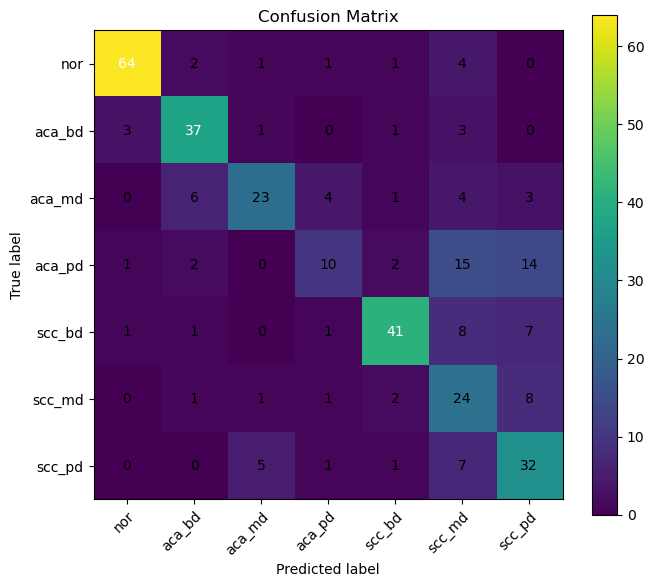


Fold B (metrics):
{
  "accuracy": 0.6358381502890174,
  "macro_f1": 0.5981408547289381,
  "loss": 1.0302280104918287,
  "acc": 0.6358381502890174
}


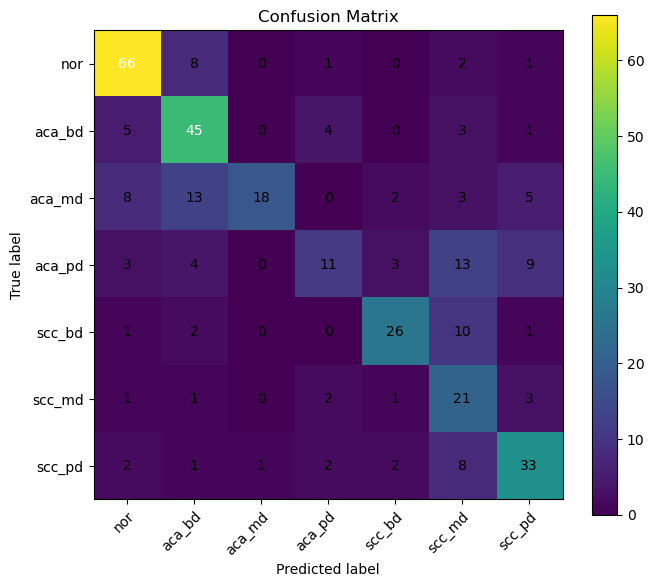


CV summary:
{
  "foldA": {
    "accuracy": 0.6695652173913044,
    "macro_f1": 0.6373968148113079,
    "loss": 1.0423588467680889,
    "acc": 0.6695652173913044
  },
  "foldB": {
    "accuracy": 0.6358381502890174,
    "macro_f1": 0.5981408547289381,
    "loss": 1.0302280104918287,
    "acc": 0.6358381502890174
  },
  "avg": {
    "accuracy": 0.6527016838401609,
    "macro_f1": 0.617768834770123
  }
}


In [30]:
#Para reporte visual
print("Fold A (metrics):")
print(json.dumps(metrics_A, indent=2))
display(IPyImage(filename=str((OUT_DIR/"foldA_resnet18"/"confusion_matrix.png").resolve())))

print("\nFold B (metrics):")
print(json.dumps(metrics_B, indent=2))
display(IPyImage(filename=str((OUT_DIR/"foldB_resnet18"/"confusion_matrix.png").resolve())))

print("\nCV summary:")
with open(OUT_DIR/"cv_summary.json","r",encoding="utf-8") as f:
    print(f.read())

En conjunto, el modelo con ResNet18 logra un desempeño estable y medio: accuracy promedio de 0.653 y macro-F1 de 0.618, con pérdidas cercanas a 1.0, y resultados consistentes entre folds (A≈0.67/0.64 vs. B≈0.64/0.60). Las matrices de confusión muestran que clasifica muy bien el tejido normal y razonablemente scc_pd / scc_bd, mientras que los mayores errores aparecen entre grados del mismo tipo tumoral (por ejemplo, aca_md con aca_bd/ aca_pd y scc_md con scc_bd/ scc_pd) y en adenocarcinoma pobremente diferenciado que se dispersa hacia scc_md/ scc_pd. Al ver las imágenes, me di cuenta que estos son muy similares morfológicamente por lo que puede que sea por eso y por el desbalance de clases.